# Question 5: Stimulus Triggered by Pairs of Spikes

For intervals of 2 ms, 4
ms, 10 ms, 20 ms and 50 ms calculate the average stimulus before a pair of
spikes separated by that interval; Do this for both the case where the spikes
are not necessarily adjacent and the case where they are. Speculate on the
role of the refractory period in any differences in the STA between the two
scenarios (adjacent vs. non-adjacent spikes)

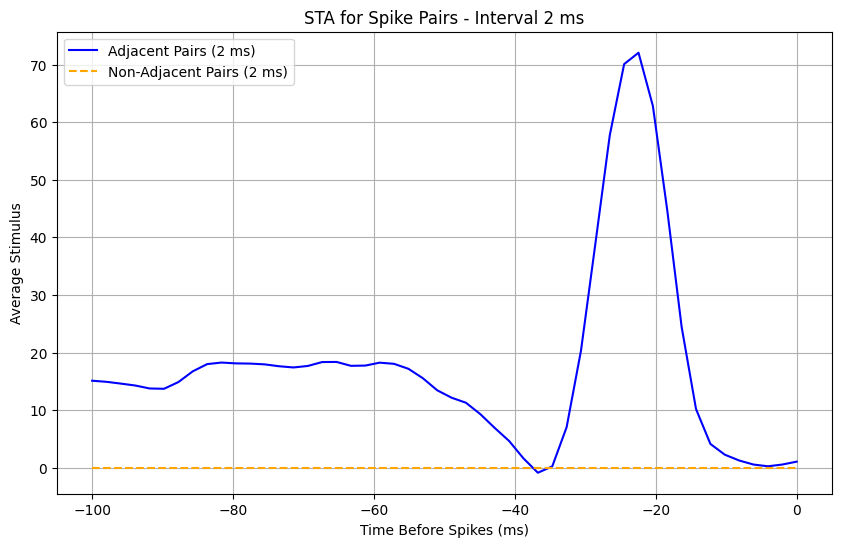

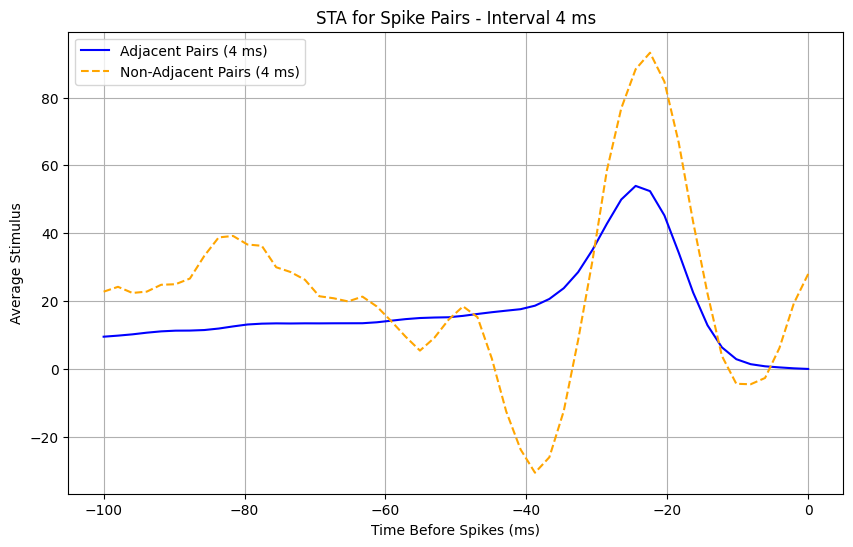

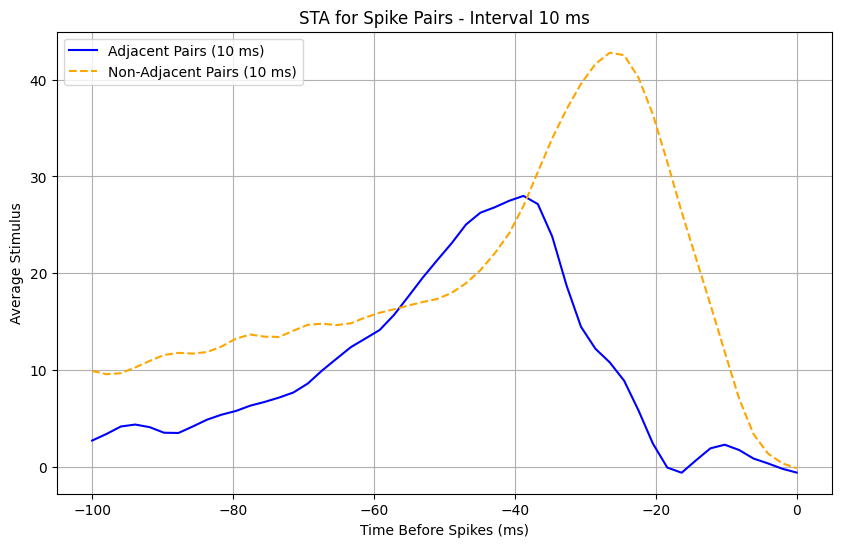

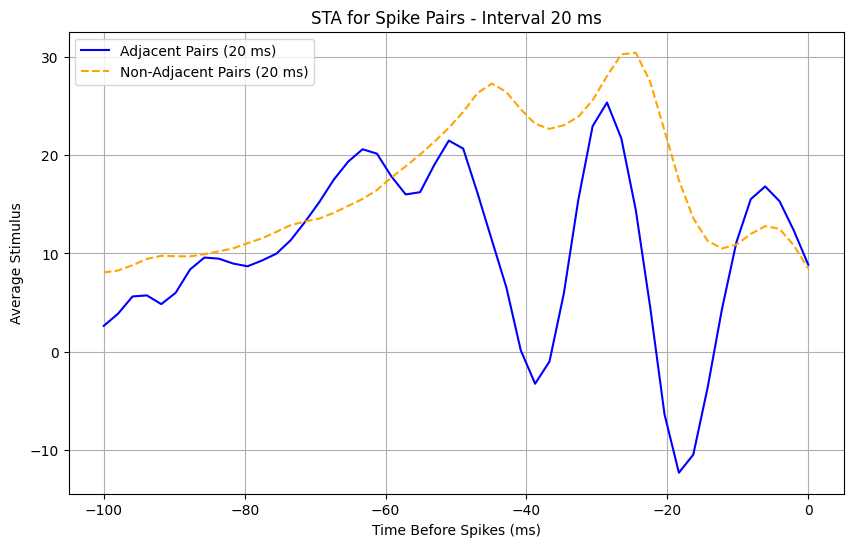

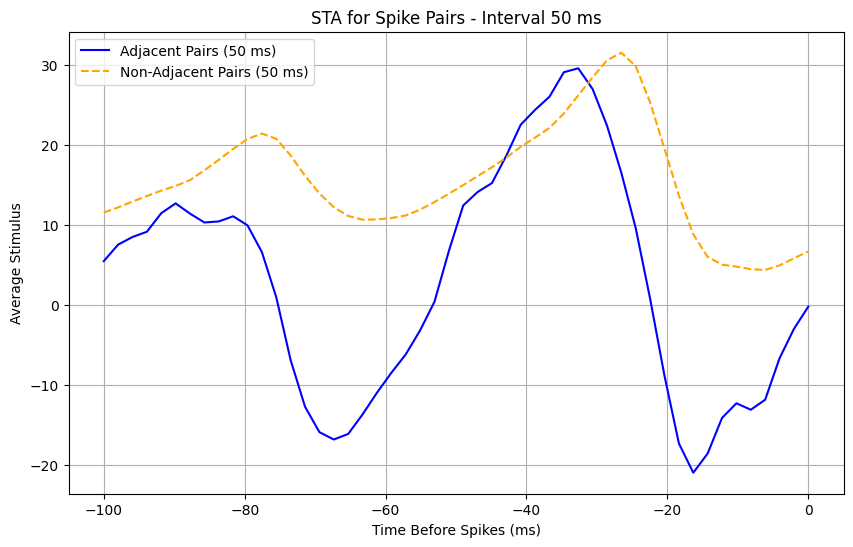

In [29]:
import numpy as np
import matplotlib.pyplot as plt

stim = np.loadtxt("stim.dat") 
rho = np.loadtxt("rho.dat")    

sampling_rate = 500
window_size_ms = 100  
window_size = int(window_size_ms / (1000 / sampling_rate)) 
intervals = [2, 4, 10, 20, 50] 
intervals_samples = [int(i / (1000 / sampling_rate)) for i in intervals]

spike_indices = np.where(rho == 1)[0]

def get_spike_pairs(spike_times, interval, adjacent=True):
    spike_pairs = []
    for i in range(len(spike_times) - 1):
        if adjacent:
            if spike_times[i + 1] - spike_times[i] == interval:
                spike_pairs.append((spike_times[i], spike_times[i + 1]))
        else:
            for j in range(i + 2, len(spike_times)):
                time_diff = spike_times[j] - spike_times[i]
                if time_diff > interval: #since sorted, can just break for efficiency
                    break
                if time_diff == interval:
                    spike_pairs.append((spike_times[i], spike_times[j]))
    return spike_pairs

for interval, interval_sample in zip(intervals, intervals_samples):
    spike_pairs_adj = get_spike_pairs(spike_indices, interval_sample, adjacent=True)
    spike_pairs_non_adj = get_spike_pairs(spike_indices, interval_sample, adjacent=False)

    sta_adj = np.zeros(window_size)
    sta_non_adj = np.zeros(window_size)

    for spike1, spike2 in spike_pairs_adj:
        if spike1 >= window_size and spike2 >= window_size:
            stim_pair = 0.5 * (stim[spike1 - window_size:spike1] + stim[spike2 - window_size:spike2])
            sta_adj += stim_pair
    if len(spike_pairs_adj) > 0:
        sta_adj /= len(spike_pairs_adj)

    for spike1, spike2 in spike_pairs_non_adj:
        if spike1 >= window_size and spike2 >= window_size:
            stim_pair = 0.5 * (stim[spike1 - window_size:spike1] + stim[spike2 - window_size:spike2])
            sta_non_adj += stim_pair
    if len(spike_pairs_non_adj) > 0:
        sta_non_adj /= len(spike_pairs_non_adj)
    time = np.linspace(-100, 0, window_size)
    plt.figure(figsize=(10, 6))
    plt.plot(time, sta_adj, label=f"Adjacent Pairs ({interval} ms)", linestyle='-', color='blue')
    plt.plot(time, sta_non_adj, label=f"Non-Adjacent Pairs ({interval} ms)", linestyle='--', color='orange')
    plt.xlabel("Time Before Spikes (ms)")
    plt.ylabel("Average Stimulus")
    plt.title(f"STA for Spike Pairs - Interval {interval} ms")
    plt.legend()
    plt.grid()
    plt.show()


[210411 258950]


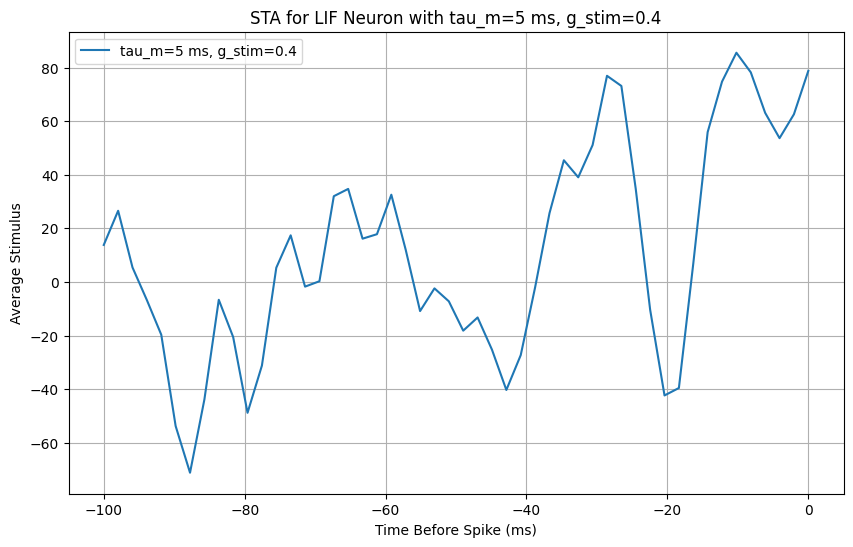

[210641 263096]


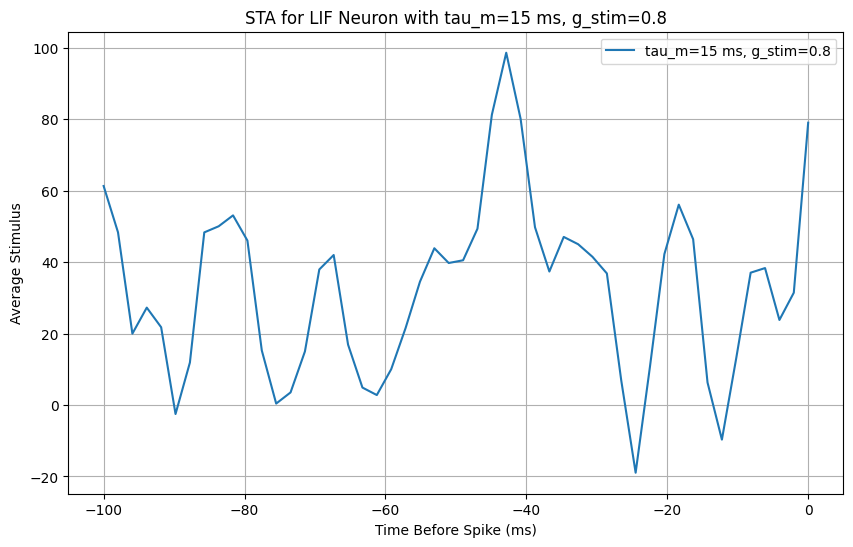

[210453 263132]


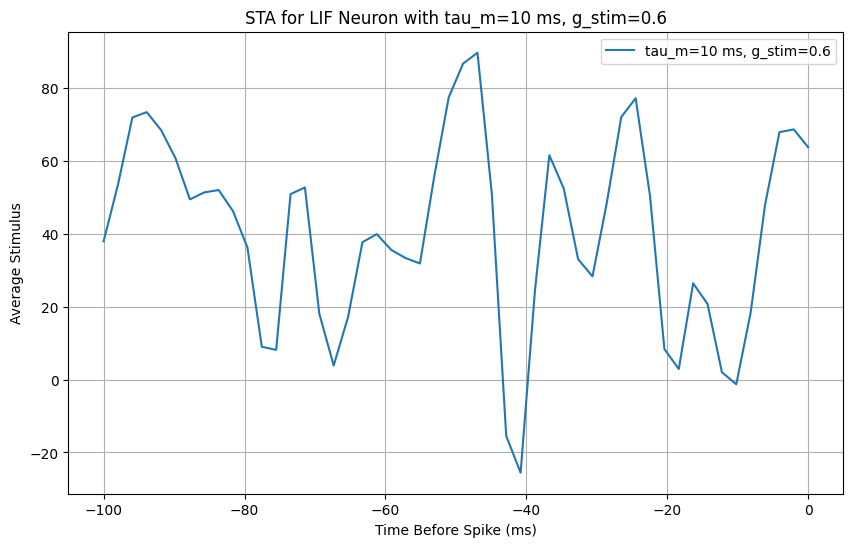

In [ ]:
#QN6
import numpy as np
import matplotlib.pyplot as plt

stim = np.loadtxt("stim.dat")
sampling_rate = 500 
dt = 1 / sampling_rate

E_L = -70.0
R_m = 10.0
tau_m = 10.0
V_t = -40.0
V_r = -70.0
I_DC = 1.5
g_stim = 0.5

window_size_ms = 100
window_size = int(window_size_ms / (1000 / sampling_rate))

time_axis = np.linspace(-window_size_ms, 0, window_size)

def lif_neuron(stimulus, E_L, R_m, tau_m, V_t, V_r, I_DC, g_stim, dt):
    V = E_L
    spikes = []
    for t, stim in enumerate(stimulus):
        I_syn = I_DC + g_stim * stim
        dV = (-(V - E_L) + R_m * I_syn) / tau_m
        V += dV * dt
        
        if V >= V_t:
            spikes.append(t)
            V = V_r  #reset potential after spike
    return np.array(spikes)

spikes = lif_neuron(stim, E_L, R_m, tau_m, V_t, V_r, I_DC, g_stim, dt)

def calculate_sta(stimulus, spikes, window_size):
    sta = np.zeros(window_size)
    valid_spikes = spikes[spikes >= window_size]
    for spike in valid_spikes:
        sta += stimulus[spike - window_size:spike]
    if len(valid_spikes) > 0:
        sta /= len(valid_spikes)
    return sta


param_sets = [
    {"tau_m": 5, "g_stim": 0.4},
    {"tau_m": 15, "g_stim": 0.8},
    {"tau_m": 10, "g_stim": 0.6}
]

for params in param_sets:
    spikes = lif_neuron(stim, E_L, R_m, params["tau_m"], V_t, V_r, I_DC, params["g_stim"], dt)
    print(spikes)

    sta = calculate_sta(stim, spikes, window_size)
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis, sta, label=f"tau_m={params['tau_m']} ms, g_stim={params['g_stim']}")
    plt.xlabel("Time Before Spike (ms)")
    plt.ylabel("Average Stimulus")
    plt.title(f"STA for LIF Neuron with tau_m={params['tau_m']} ms, g_stim={params['g_stim']}")
    plt.grid()
    plt.legend()
    plt.show()
